# Graph coloring problem
Given an undirected graph and a set of colors, color the graph so that adjacent nodes are different colors

Solved using Pyomo

In [1]:
# import necessary packages
import time
import numpy as np
import numpy.random as random

import dimod
import networkx as nx

from pyomo.environ import *
from pyomo.opt import SolverFactory, SolverManagerFactory

## Generate graph

30 43


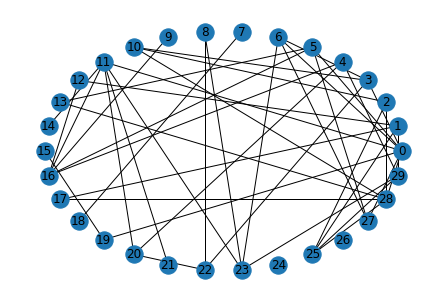

In [2]:
# graph = nx.Graph()
# graph.add_nodes_from([0,4])
# graph.add_edges_from([(0,1),(0,4),(1,2),(1,3),(1,4),(2,3),(3,4)])

# # graph.nodes.sort()
# print(type(graph.nodes))

# # house positions
# pos = {0: (0.5, 2.0), 1: (1, 1), 2: (1, 0), 3: (0, 0),  4: (0, 1)}

# nx.draw(graph, pos=pos, with_labels=True)

# generate random graph
# number of nodes
num_nodes = 30
# edge generation probability
p = 0.1
# seed (optional)
seed = 45
#generate graph
graph = nx.gnp_random_graph(num_nodes,p,seed)

pos = nx.circular_layout(graph)

# draw graph
nx.draw(graph, pos=pos, with_labels=True)

# number of colors
num_colors = max(d for _, d in graph.degree()) + 1


print(len(graph.nodes), len(graph.edges))

## Build problem model

In [25]:
# instantiate
model = ConcreteModel()

# define variables // pyomo indexes from 1
model.x = Var([i+1 for i in range(num_nodes*num_colors)], domain=Binary, bounds=(0,1))
# dictionary to assign node/color pairing to certain variable
var_dict = {}
i = 1
for n in graph.nodes:
    for c in range(num_colors):
        var_dict[(n+1,c+1)] = model.x[i]
        i += 1
        
# variables to keep track of colors
model.c = Var([i+1 for i in range(num_colors)], domain=Binary, bounds=(0,1))
for i in model.c:
    print(i)
# No objective
obj = 0
for c in model.c:
    obj += model.c[c]
model.OBJ = Objective(expr = obj)

# Set constraints
# one-hot constraint
model.one_hot = ConstraintList()
for n in graph.nodes:
    model.one_hot.add(expr = sum(var_dict[(n+1,c+1)]*model.c[c+1] for c in range(num_colors)) == 1)
    
# ajacent edge nodes constraint
model.adj = ConstraintList()
for n,m in graph.edges:
    for c in range(num_colors):
        model.adj.add(expr = var_dict[(n+1,c+1)]*model.c[c+1] + var_dict[(m+1,c+1)]*model.c[c+1] <= 1)
        
print(len(model.x))        

model.one_hot.pprint()

1
2
3
4
5
6
7
8
9
10
100
one_hot : Size=10, Index=one_hot_index, Active=True
    Key : Lower : Body                                                                                                                              : Upper : Active
      1 :   1.0 :           x[1]*c[1] + x[2]*c[2] + x[3]*c[3] + x[4]*c[4] + x[5]*c[5] + x[6]*c[6] + x[7]*c[7] + x[8]*c[8] + x[9]*c[9] + x[10]*c[10] :   1.0 :   True
      2 :   1.0 :  x[11]*c[1] + x[12]*c[2] + x[13]*c[3] + x[14]*c[4] + x[15]*c[5] + x[16]*c[6] + x[17]*c[7] + x[18]*c[8] + x[19]*c[9] + x[20]*c[10] :   1.0 :   True
      3 :   1.0 :  x[21]*c[1] + x[22]*c[2] + x[23]*c[3] + x[24]*c[4] + x[25]*c[5] + x[26]*c[6] + x[27]*c[7] + x[28]*c[8] + x[29]*c[9] + x[30]*c[10] :   1.0 :   True
      4 :   1.0 :  x[31]*c[1] + x[32]*c[2] + x[33]*c[3] + x[34]*c[4] + x[35]*c[5] + x[36]*c[6] + x[37]*c[7] + x[38]*c[8] + x[39]*c[9] + x[40]*c[10] :   1.0 :   True
      5 :   1.0 :  x[41]*c[1] + x[42]*c[2] + x[43]*c[3] + x[44]*c[4] + x[45]*c[5] + x[46]*c[6] + x

## Solve

In [ ]:
instance = model.create_instance()
opt = SolverFactory('bonmin')

results = opt.solve(model) 
results.write()

## Solution

In [ ]:
model.display()

In [ ]:
model.OBJ.display()

## redraw graph

In [ ]:
# colormap
colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'grey', 'pink']
colormap = np.empty(len(graph.nodes), dtype=object)
for (n,c) in var_dict:
    if var_dict[(n,c)].value > 0.5:
        print(n,c,model.c[c].value)
        if model.c[c].value > 0.5:
            colormap[n-1] = colors[c-1]
        
sorted_nodes = np.array(sorted(graph.nodes))        
        
# draw graph
print('\n', graph.nodes, colormap)
nx.draw(graph, pos=pos, node_color=colormap, with_labels=True)

## NetworkX

In [3]:
start = time.time()
d = nx.coloring.greedy_color(graph, strategy='random_sequential')
elapsed = time.time() - start
print("Solved in %.2f seconds" % elapsed)
print(1+max(d.values()))
print(d)

Solved in 0.00 seconds
5
{13: 0, 27: 0, 11: 0, 24: 0, 12: 0, 22: 0, 7: 0, 20: 1, 23: 1, 5: 1, 6: 2, 16: 2, 18: 1, 8: 2, 9: 0, 2: 0, 17: 0, 21: 1, 26: 0, 14: 1, 15: 0, 29: 0, 10: 1, 3: 3, 28: 2, 25: 1, 19: 1, 0: 4, 4: 3, 1: 2}



 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] [4 2 0 3 3 1 2 0 2 0 1 0 0 0 1 0 2 0 1 1 1 1 0 1 0 1 0 0 2 0]


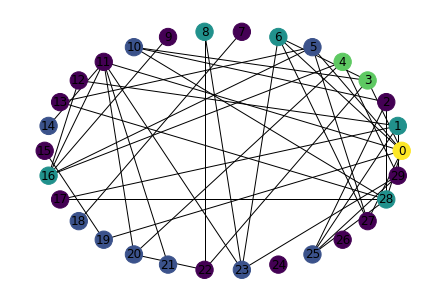

In [4]:
# colormap
colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'grey', 'pink']
colormap = np.empty(len(graph.nodes), dtype=object)
for i in d:
    colormap[i] = d[i]
        
sorted_nodes = np.array(sorted(graph.nodes))        
        
# draw graph
print('\n', graph.nodes, colormap)
nx.draw(graph, pos=pos, node_color=colormap, with_labels=True)